### PyTorch MNIST Example similar to TensorFlow Tutorial

Refer to https://www.tensorflow.org/versions/master/tutorials/mnist/pros/

PyTorch 0.1.6 and torchvision 0.1.7

In [1]:
%pylab
%matplotlib inline
%load_ext watermark
%watermark -v -p numpy,torch,torchvision

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib
CPython 3.5.2
IPython 5.1.0

numpy 1.11.3
torch n
torchvision n


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

- MnistNet inherit from nn.Module class.
- MnistNet must implement forward method.
- layers instantiated in \__init__, but actual graph is created in forward method.
- functional method like pooling, activation are in torch.nn.functional
- explicitly specify padding and stride, otherwise default padding=0, stride=1 applied
- Conv2d(in_channels, out_channels, kernel_size), weight/bias is uniform dist. with -1/sqrt(n_units)~+1/sqrt(n_units)
- Linear(in_features, out_features), weight/bias is uniform dist. with -1/sqrt(n_units)~+1/sqrt(n_units)
- model.conv1.weight, moedel.conv1.bias, .. etc
- dropout default prob. p=0.5 applied when training=True

In [3]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        # input is 28x28
        # padding=2 for same padding
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        # feature map size is 14*14 by pooling
        # padding=2 for same padding
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        # feature map size is 7*7 by pooling
        self.fc1 = nn.Linear(64*7*7, 1024)
        self.fc2 = nn.Linear(1024, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64*7*7)   # reshape Variable
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
model = MnistModel()
model

MnistModel (
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear (3136 -> 1024)
  (fc2): Linear (1024 -> 10)
)

- dataset.MNIST load train-images when train=True
- dataset.MNIST load t10k-images when train=False
- pixel value divided by 255 with tranform.ToTensor()

In [4]:
batch_size = 50
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

Processing
Done!


In [5]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=1000)

- model.parameters return all weights and biases

In [6]:
for p in model.parameters():
    print(p.size())

torch.Size([32, 1, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([1024, 3136])
torch.Size([1024])
torch.Size([10, 1024])
torch.Size([10])


In [7]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

- model.train() makes training=True, model.eval() makes traingin=False

In [8]:
model.train()
train_loss = []
train_accu = []
i = 0
for epoch in range(15):
    for data, target in train_loader:
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()    # calc gradients
        train_loss.append(loss.data[0])
        optimizer.step()   # update gradients
        prediction = output.data.max(1)[1]   # first column has actual prob.
        accuracy = prediction.eq(target.data).sum()/batch_size*100
        train_accu.append(accuracy)
        if i % 1000 == 0:
            print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.data[0], accuracy))
        i += 1

Train Step: 0	Loss: 2.312	Accuracy: 4.000
Train Step: 1000	Loss: 0.102	Accuracy: 96.000
Train Step: 2000	Loss: 0.079	Accuracy: 98.000
Train Step: 3000	Loss: 0.014	Accuracy: 100.000
Train Step: 4000	Loss: 0.162	Accuracy: 98.000
Train Step: 5000	Loss: 0.058	Accuracy: 98.000
Train Step: 6000	Loss: 0.024	Accuracy: 100.000
Train Step: 7000	Loss: 0.050	Accuracy: 100.000
Train Step: 8000	Loss: 0.003	Accuracy: 100.000
Train Step: 9000	Loss: 0.014	Accuracy: 100.000
Train Step: 10000	Loss: 0.164	Accuracy: 98.000
Train Step: 11000	Loss: 0.125	Accuracy: 98.000
Train Step: 12000	Loss: 0.002	Accuracy: 100.000
Train Step: 13000	Loss: 0.005	Accuracy: 100.000
Train Step: 14000	Loss: 0.044	Accuracy: 98.000
Train Step: 15000	Loss: 0.087	Accuracy: 96.000
Train Step: 16000	Loss: 0.002	Accuracy: 100.000
Train Step: 17000	Loss: 0.035	Accuracy: 98.000


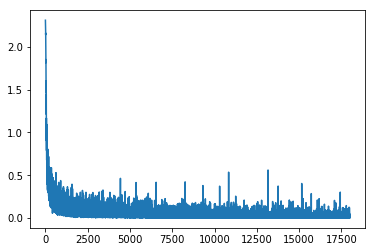

In [9]:
plt.plot(np.arange(len(train_loss)), train_loss)

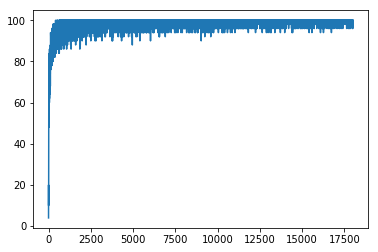

In [10]:
plt.plot(np.arange(len(train_accu)), train_accu)

- volatile=True is used in inference mode. it makes stopping histoy recording for backward().

In [11]:
model.eval()
correct = 0
for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

print('\nTest set: Accuracy: {:.2f}%'.format(100. * correct / len(test_loader.dataset)))


Test set: Accuracy: 99.29%
